# Setup

Imports and definitions

In [1]:
# Imports
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from pandas import pandas as pd
from matplotlib import pyplot
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


# Definitions
MOVEMENT_TIME_THRESHOLD = 10
NON_SUSPICIOUS_MOVEMENT_TIME_THRESHOLD = 3
RANDOM_STATE = 42


Functions

In [2]:
# Keep only the first entry for each user
def keep_first_entry_per_user(dataframe):
    return dataframe[~dataframe['uuid'].duplicated(keep='first')].reset_index(drop=True)


# Remove the first entry for each user
def remove_first_entry_per_user(dataframe):
    drop_indices = []
    seen = set()
    
    for index, row in dataframe.iterrows():
        uuid = row['uuid']
        if uuid in seen:
            continue
        drop_indices.append(index)
        seen.add(uuid)
        
    return dataframe.drop(index=drop_indices).reset_index(drop=True)


# Remove entries with movement_time higher than threshold
def remove_high_mt_outliers(dataframe, threshold):
    return dataframe[dataframe['movement_time'] <= threshold]


# Get entries with suspiciously high movement times
def get_suspicious_movement_times(dataframe):
    suspicious_uuids = []
    
    for _ , row in dataframe.iterrows():
        if row['movement_time'] > NON_SUSPICIOUS_MOVEMENT_TIME_THRESHOLD:
            suspicious_uuids.append(row['uuid'])
    
    return dataframe[dataframe['uuid'].isin(suspicious_uuids)]


# Categorize users based on average throughput
def get_user_category(avg_through_put, min, max):
        if avg_through_put < min:
            return 'low'
        elif avg_through_put < max:
            return 'medium'
        else:
            return 'high'
        

# Aggregate throughput per user using fitts' law
def aggregate_throughput_per_user(dataframe):
    
    grouped = dataframe.groupby('uuid').agg({
        'index_difficulty': 'sum',
        'movement_time': 'sum',
        'misses': 'sum',
        'device': 'first',
        'computer_time': 'first',
        'user_age': 'first'
    }).reset_index()
    
    grouped.loc[:,'avg_through_put'] = grouped['index_difficulty'] / grouped['movement_time']
    grouped.loc[:,'total_misses'] = grouped['misses']

    throughput_per_user = grouped[['uuid','total_misses','computer_time','user_age','device', 'avg_through_put']].copy()
    
    mouse_users_df = throughput_per_user[throughput_per_user['device'] == 'mouse']
    trackpad_users_df = throughput_per_user[throughput_per_user['device'] == 'trackpad']
    
    min_mouse_tp, max_mouse_tp = mouse_users_df['avg_through_put'].quantile([0.33, 0.66])
    min_trackpad_tp, max_trackpad_tp = trackpad_users_df['avg_through_put'].quantile([0.33, 0.66])
    
    print(f"Mouse TP thresholds: min={min_mouse_tp}, max={max_mouse_tp}")
    print(f"Trackpad TP thresholds: min={min_trackpad_tp}, max={max_trackpad_tp}")
    
    
    for index, row in throughput_per_user.iterrows():
        if row['device'] == 'mouse':
            category = get_user_category(row['avg_through_put'], min_mouse_tp, max_mouse_tp)
        else:
            category = get_user_category(row['avg_through_put'], min_trackpad_tp, max_trackpad_tp)
        
        throughput_per_user.at[index, 'performance_category'] = category
    
    return throughput_per_user


# Initialization

### Read csv file, sort and check the data

In [3]:
FOLDER = 'data/'
FILE = 'data.csv'
df = pd.read_csv(FOLDER + FILE)
df.sort_values('movement_time', ascending=False)

,uuid,user_age,device,computer_time,target_object_id,misses,movement_time,index_difficulty
774,f03cac9f-8548-43aa-a2b9-de0d4e3135f6,54,Mouse,10,21,2,35.063,2.996
506,fa2558fd-5af8-495d-9bd1-cc550f0964cb,22,Mouse,5,16,0,24.554,4.203
736,8218f964-9ddc-4369-885f-3851eddecee7,61,Mouse,1,13,0,7.676,2.659
392,71a9bf81-f720-4655-8f6f-4f6728e37dd2,26,Mouse,6,11,5,6.643,1.839
781,f03cac9f-8548-43aa-a2b9-de0d4e3135f6,54,Mouse,10,0,3,5.981,2.055
...,...,...,...,...,...,...,...,...
720,9ccf3d9b-909d-4dd4-857c-197fbb349584,23,Mouse,8,8,0,0.380,1.796
528,fa2558fd-5af8-495d-9bd1-cc550f0964cb,22,Mouse,5,20,0,0.375,1.275
723,9ccf3d9b-909d-4dd4-857c-197fbb349584,23,Mouse,8,3,0,0.367,1.346
728,9ccf3d9b-909d-4dd4-857c-197fbb349584,23,Mouse,8,7,0,0.363,2.449


In [4]:
# Create a dataframe with only one entry per user
total_users_df = keep_first_entry_per_user(df).copy()
total_users_df = total_users_df.drop(columns=['target_object_id', 'misses', 'movement_time', 'index_difficulty'])
total_users_df.sort_values('computer_time', ascending=False)
total_users_df.head(5)

,uuid,user_age,device,computer_time
0,cd1842cb-4771-4c16-9de8-cc3e1bf66275,27,Trackpad,14
1,2efdf886-71a0-492f-9a1a-74f47b9f0ea1,25,Mouse,14
2,849f6e05-bde2-4665-ab3d-28ea8786feb3,22,Mouse,5
3,77d00f41-edbe-45ab-a40e-23cfebac5bd9,22,Trackpad,5
4,94b750bc-66df-494b-9246-6c37272a666f,49,Mouse,6


In [5]:
# Create an index mapping for UUIDs to unique integers as strings
uuid_to_index = {uuid: str(i) for i, uuid in enumerate(df['uuid'].unique(), start=1)}

# Add a new column 'uuid_index' to the original DataFrame
df['uuid_index'] = df['uuid'].map(uuid_to_index)


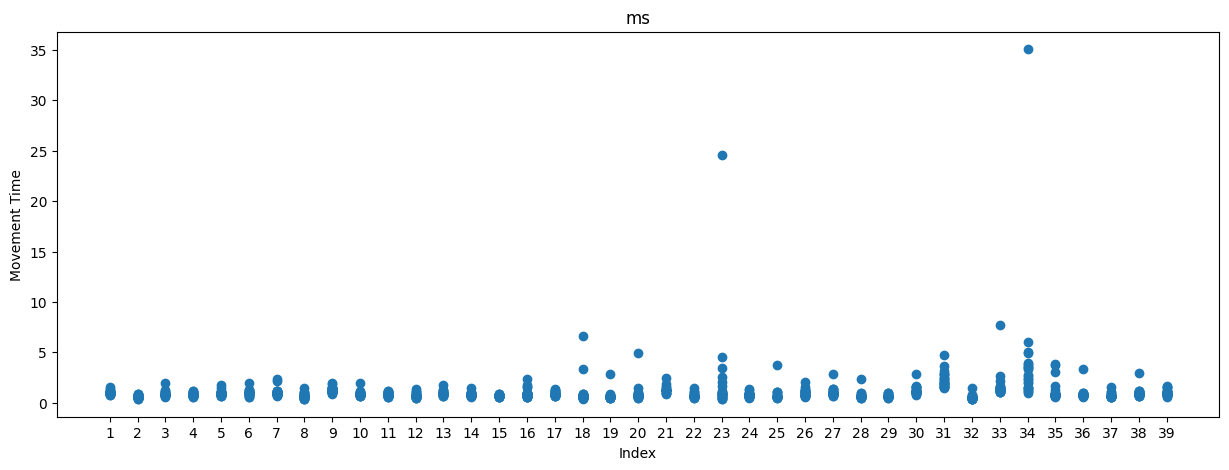

In [6]:
# Plot movement_time with uuid_index
pyplot.figure(figsize=(15, 5))
pyplot.scatter(df['uuid_index'], df['movement_time'])
pyplot.xlabel('Index')
pyplot.ylabel('Movement Time')
pyplot.title('ms')
pyplot.show()

# Data cleanup

### Removing the first clicks

We remove the first entry from users because during testing, the timer calculating the clicking time started right after clicking Accept to the consent form, and no countdown was issued so many users were shocked they were instantly brought into testing.

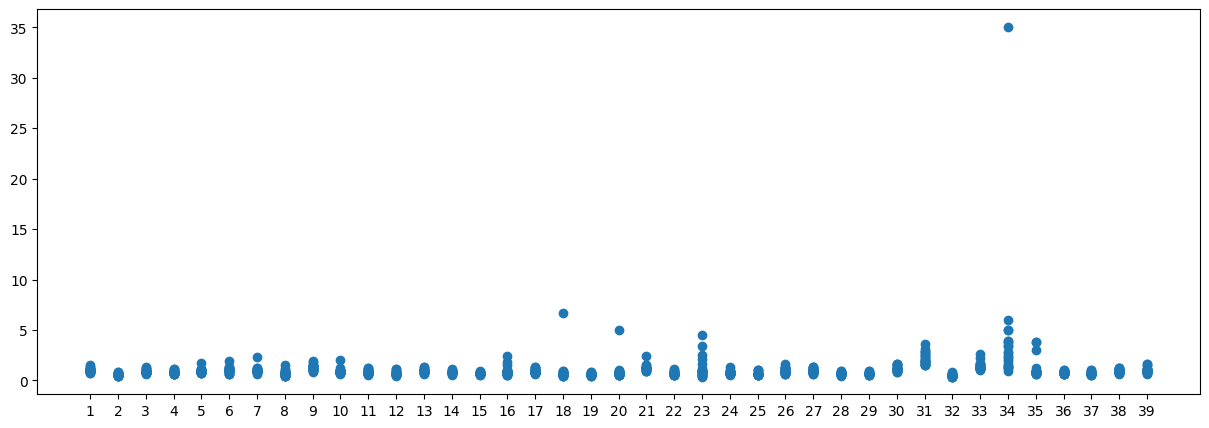

In [7]:
# Remove the first entry for every user
main_data = remove_first_entry_per_user(df).copy()
main_data.shape

pyplot.figure(figsize=(15, 5))
pyplot.scatter(main_data['uuid_index'], main_data['movement_time'])

### Removing the outliers

We decided to remove outliers from the data by removing any events where the users spent more than 10 seconds to click on the next object.

(857, 9)

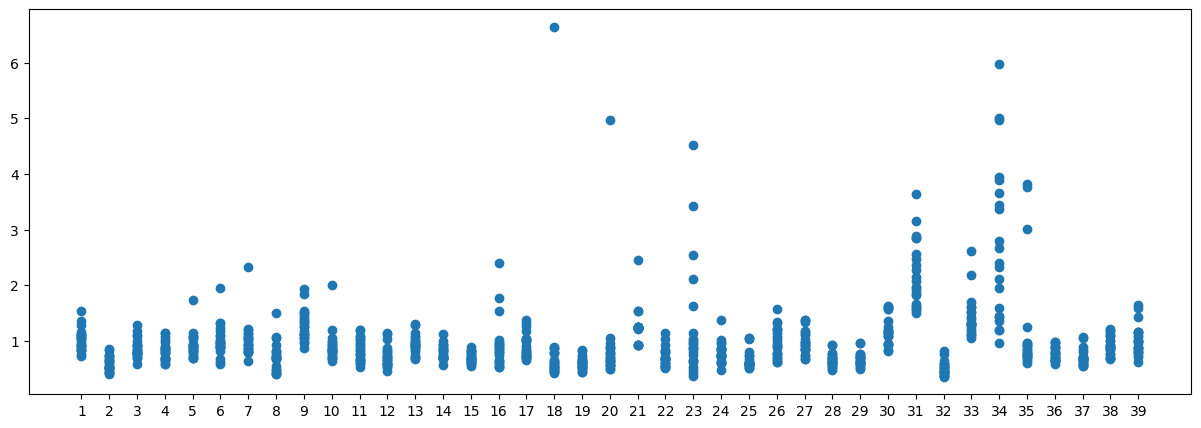

In [8]:
data_cleaned = remove_high_mt_outliers(main_data, MOVEMENT_TIME_THRESHOLD).copy()
data_cleaned.loc[:, 'device'] = data_cleaned['device'].str.lower()

pyplot.figure(figsize=(15, 5))
pyplot.scatter(data_cleaned['uuid_index'], data_cleaned['movement_time'])
data_cleaned.shape


(131, 9)

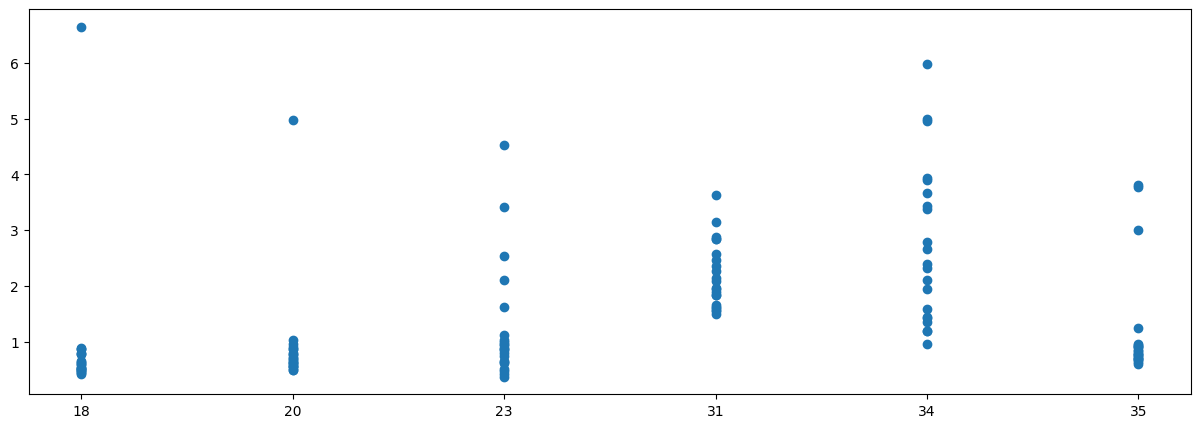

In [9]:
# Show the suspicious users who have high movement_time but was not their first data entry
suspicious_uuids = get_suspicious_movement_times(data_cleaned)

pyplot.figure(figsize=(15, 5))
pyplot.scatter(suspicious_uuids['uuid_index'], suspicious_uuids['movement_time'])
suspicious_uuids.shape

# Model training

### Calculate throughput per user and visualize distribution

In [10]:
# Calculate the Throughput performance according to Fitts' Law
# TP = sum(ID) / sum(MT) for each user
user_based_data = aggregate_throughput_per_user(data_cleaned)
user_based_data.sort_values('device')
user_based_data.head(5)

Mouse TP thresholds: min=2.4098172214276206, max=3.041541602815436
Trackpad TP thresholds: min=2.2972007398671126, max=2.507317024316293


,uuid,total_misses,computer_time,user_age,device,avg_through_put,performance_category
0,044db93c-82bc-48f1-aac1-fa16380fe30e,1,6,56,mouse,2.222248,low
1,1ed3368e-ee51-4eec-a627-feba6f4a91c8,0,11,57,mouse,2.958651,medium
2,231c917b-cd39-4469-8f5b-e9e3bf7c414e,0,8,24,trackpad,1.725171,low
3,2bd9e194-6807-4af6-a35c-fd4fdc85f738,2,8,24,mouse,3.040767,medium
4,2efdf886-71a0-492f-9a1a-74f47b9f0ea1,0,14,25,mouse,3.648722,high


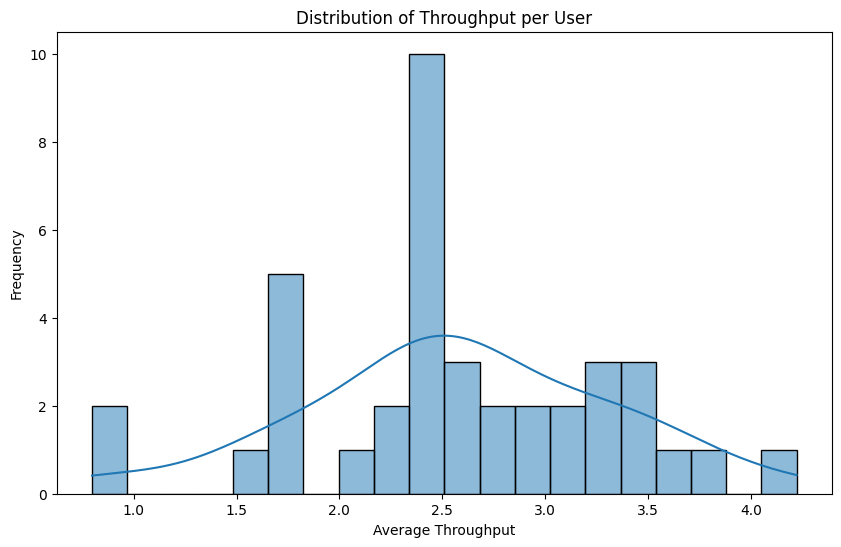

In [11]:
# Plot the distribution of average throughput per user
pyplot.figure(figsize=(10, 6))
sns.histplot(user_based_data['avg_through_put'], bins=20, kde=True)
pyplot.xlabel('Average Throughput')
pyplot.ylabel('Frequency')
pyplot.title('Distribution of Throughput per User')
pyplot.show()

### Split data and train models

In [12]:
# Create a copy of user_based_data and encode the device column
encoded_user_based_data = user_based_data.copy()
label_encoder = LabelEncoder()
encoded_user_based_data.loc[:, 'device_encoded'] = label_encoder.fit_transform(encoded_user_based_data['device'])

X = encoded_user_based_data[['user_age', 'computer_time', 'device_encoded']]
y = encoded_user_based_data['performance_category']


classification_models = {
    "Random Forest": RandomForestClassifier( random_state=RANDOM_STATE),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "SVM": SVC()
}

X.head(5)

,user_age,computer_time,device_encoded
0,56,6,0
1,57,11,0
2,24,8,1
3,24,8,0
4,25,14,0


Train - test split was chosen as 65% - 35% since our dataset is very small, an 80% - 20% split gave bad results

In [13]:
# Splitting the data and training 3 models with hyperparameter tuning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=RANDOM_STATE)

param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [3, 5, 7, 10, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    "SVM": {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf', 'linear']
    }
}

best_models = {}
best_model_params = {}

for name, model in classification_models.items():
    
    grid_search = GridSearchCV(
        model, 
        param_grids[name], 
        cv=5, 
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    best_model_params[name] = grid_search.best_params_
    test_score = grid_search.score(X_test, y_test)

print(best_model_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'Random Forest': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, 'K-Nearest Neighbors': {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}, 'SVM': {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}}


In [14]:
# Train models with the best hyperparameters and evaluate
models_with_best_params = {
    "K Nearest Neighbors": KNeighborsClassifier(**best_model_params["K-Nearest Neighbors"]),
    "Random Forest": RandomForestClassifier(**best_model_params["Random Forest"], random_state=RANDOM_STATE),
    "SVM": SVC(**best_model_params["SVM"])
}

print(models_with_best_params)

for name, model in models_with_best_params.items():
    model.fit(X_train, y_train)
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"{name:20} - Train R²: {train_score:.4f}, Test R²: {test_score:.4f}")

{'K Nearest Neighbors': KNeighborsClassifier(metric='euclidean', n_neighbors=3), 'Random Forest': RandomForestClassifier(random_state=42), 'SVM': SVC(C=1)}
K Nearest Neighbors  - Train R²: 0.6400, Test R²: 0.3571
Random Forest        - Train R²: 0.9600, Test R²: 0.5000
SVM                  - Train R²: 0.5200, Test R²: 0.5714


### Visualize results and test all combinations

Model only works on users with age from 19 to 76 and on daily computer hours between 1 to 16

This is because our data only includes those ranges, any values outside those ranges are inaccurate

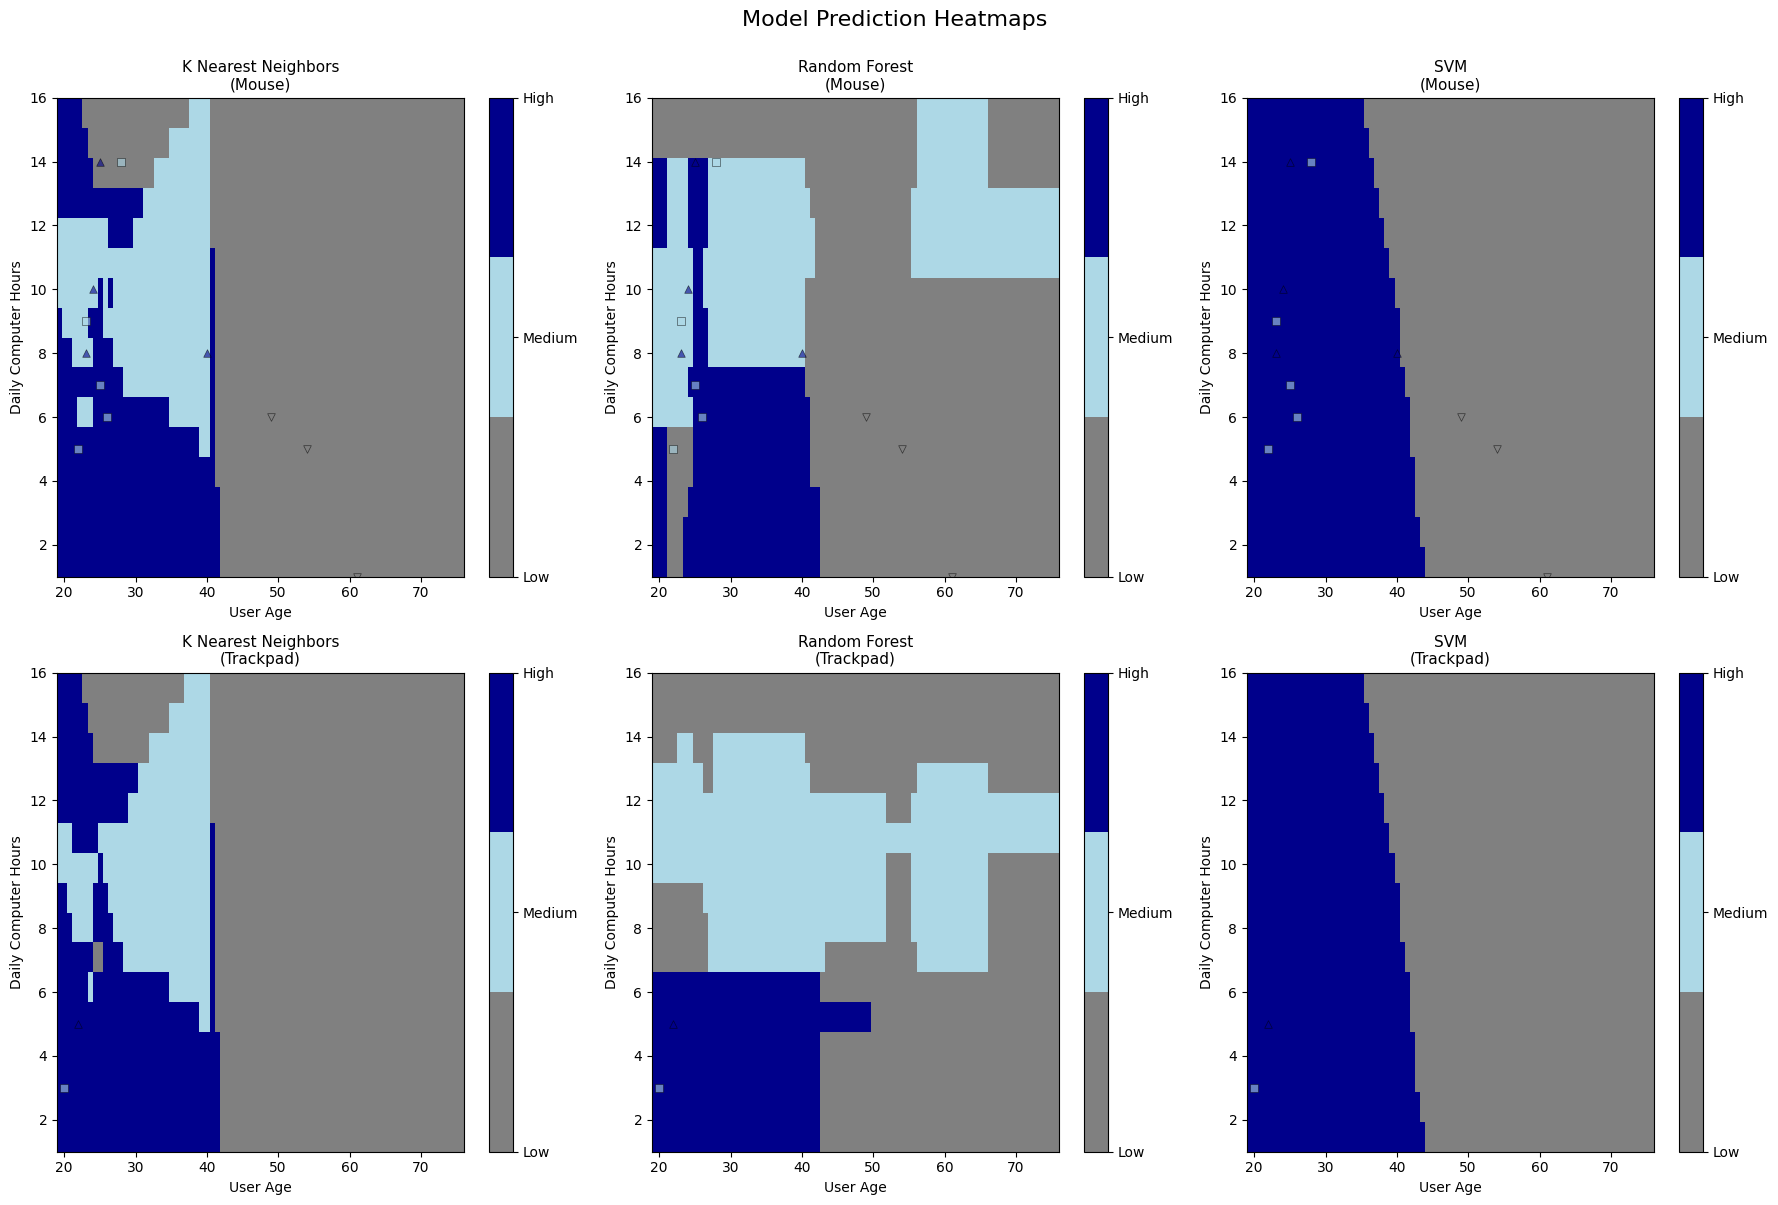

In [15]:
# Create a grid of values for predictions
age_range = np.linspace(X['user_age'].min(), X['user_age'].max(), 80)
computer_time_range = np.linspace(X['computer_time'].min(), X['computer_time'].max(), 16)

# Create meshgrid for both devices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Prediction Heatmaps', fontsize=16, y=1.00)

devices = [0, 1]  # 0 for one device, 1 for the other
device_names = ['Mouse', 'Trackpad']

for device_idx, (device_val, device_name) in enumerate(zip(devices, device_names)):
    for model_idx, (name, model) in enumerate(models_with_best_params.items()):
        ax = axes[device_idx, model_idx]
        
        # Create a grid of predictions
        predictions = np.zeros((len(computer_time_range), len(age_range)))
        
        for i, comp_time in enumerate(computer_time_range):
            for j, age in enumerate(age_range):

                X_pred = pd.DataFrame([[age, comp_time, device_val]], columns=['user_age', 'computer_time', 'device_encoded'])
                pred = model.predict(X_pred)[0]
                # Map categories to numbers for visualization
                if pred == 'low':
                    predictions[i, j] = 0
                elif pred == 'medium':
                    predictions[i, j] = 1
                else:  # high
                    predictions[i, j] = 2
        
        # Create heatmap
        custom_cmap = ListedColormap(['grey', 'lightblue', 'darkblue'])
        im = ax.imshow(predictions, cmap=custom_cmap, aspect='auto', origin='lower',
                      extent=[age_range.min(), age_range.max(), 
                             computer_time_range.min(), computer_time_range.max()])
        
        ax.set_xlabel('User Age', fontsize=10)
        ax.set_ylabel('Daily Computer Hours', fontsize=10)
        ax.set_title(f'{name}\n({device_name})', fontsize=11)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2])
        cbar.set_ticklabels(['Low', 'Medium', 'High'])
        
        # Scatter actual data points on top
        device_mask = X_test['device_encoded'] == device_val
        X_test_device = X_test[device_mask]
        y_test_device = y_test[device_mask]
        
        for category, marker, color in [('low', 'v', 'grey'), 
                                        ('medium', 's', 'lightblue'), 
                                        ('high', '^', 'darkblue')]:
            mask = y_test_device == category
            if mask.sum() > 0:
                ax.scatter(X_test_device[mask]['user_age'], 
                          X_test_device[mask]['computer_time'],
                          c=color, marker=marker, s=30, 
                          edgecolors='black', linewidth=0.5,
                          alpha=0.6, label=f'Actual {category}')

plt.tight_layout()
plt.show()

# Conclusion

Our models are getting skewed accuracies because of a very small dataset. We have cleaned the data by removing outliers and tuning hyperparameters for the models, so currently the only solution to our issue is to increase the dataset size. We will gather more data passively and test the new dataset on the same framework, in hope that we get better results for each model.